## - Optiver Trading At The Close

* **Vishnupriya Santhosh (vs263)**

## Submission Score :
* best entry score: 5.3359
* Second best entry score : 5.336

In [ ]:
###### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py

/kaggle/input/optiver-trading-at-the-close/train.csv

/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv

/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv

/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv

/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so

/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


# Description of the notebook

**- Importing Libraries**
- Data loadong and description
- Exploratory Data Analysis (EDA)
- Data Preparation
- Reducing the memory usage
- Creating dataset with Data loaders
- Train test split
- Creating sequences for model building
- Model Implementation
    - LSTM 1
    - LSTM 2
    - LSTM 3
- Conclusion
- Notebook submission code (Optiver API)**

### Importing libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd, numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
temp = dict(layout = go.Layout(font = dict(family="Franklin Gothic", size=12), width = 1500))

import torch
from torch import nn
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset, random_split
import time

import tensorflow as tf
import random as python_random

import keras
from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

### Data loading and description

In [ ]:
df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [ ]:
df.shape

(5237980, 17)

#### dataset_description()
* Takes a DataFrame (df) as input and returns a new DataFrame 'result' summarizing various attributes of the input dataset.
* Takes each attribute from the original dataset and checks if they are 'unique', its 'cardinality', has 'null' values etc.
* The function returns another dataset that contains the data description of the original dataset

In [ ]:
def dataset_descripton(df):

    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

dataset_descripton(df)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0,192,199,int64
date_id,False,481,False,0.00,0,454,480,int64
seconds_in_bucket,False,55,False,0.00,0,310,540,int64
imbalance_size,False,2971863,True,0.00,3180602.69,546916.21,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0.00,1,1,-1,int64
reference_price,False,28741,True,0.00,0.999812,1.00235,1.002129,float64
matched_size,False,2948862,True,0.00,13380276.64,12626296.98,24073677.32,float64
far_price,False,95739,True,55.26,NaN,1.017416,1.000859,float64
near_price,False,84625,True,54.55,NaN,1.004964,1.001494,float64
bid_price,False,28313,True,0.00,0.999812,1.001889,1.002129,float64


#### Total stocks = 200 , Number of dates = 481 , Number of seconds = 55
- Total number of expected datapoints :
    (total stocks) * (dates) * (seconds)
     200 * 481 * 55  =  5291000
- But the number of data points in the dataset are 5237980, so there are some missing points in the dataset.

### Exploratory Data Analysis (EDA)

In [ ]:
cols_to_plot = ['imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', ]

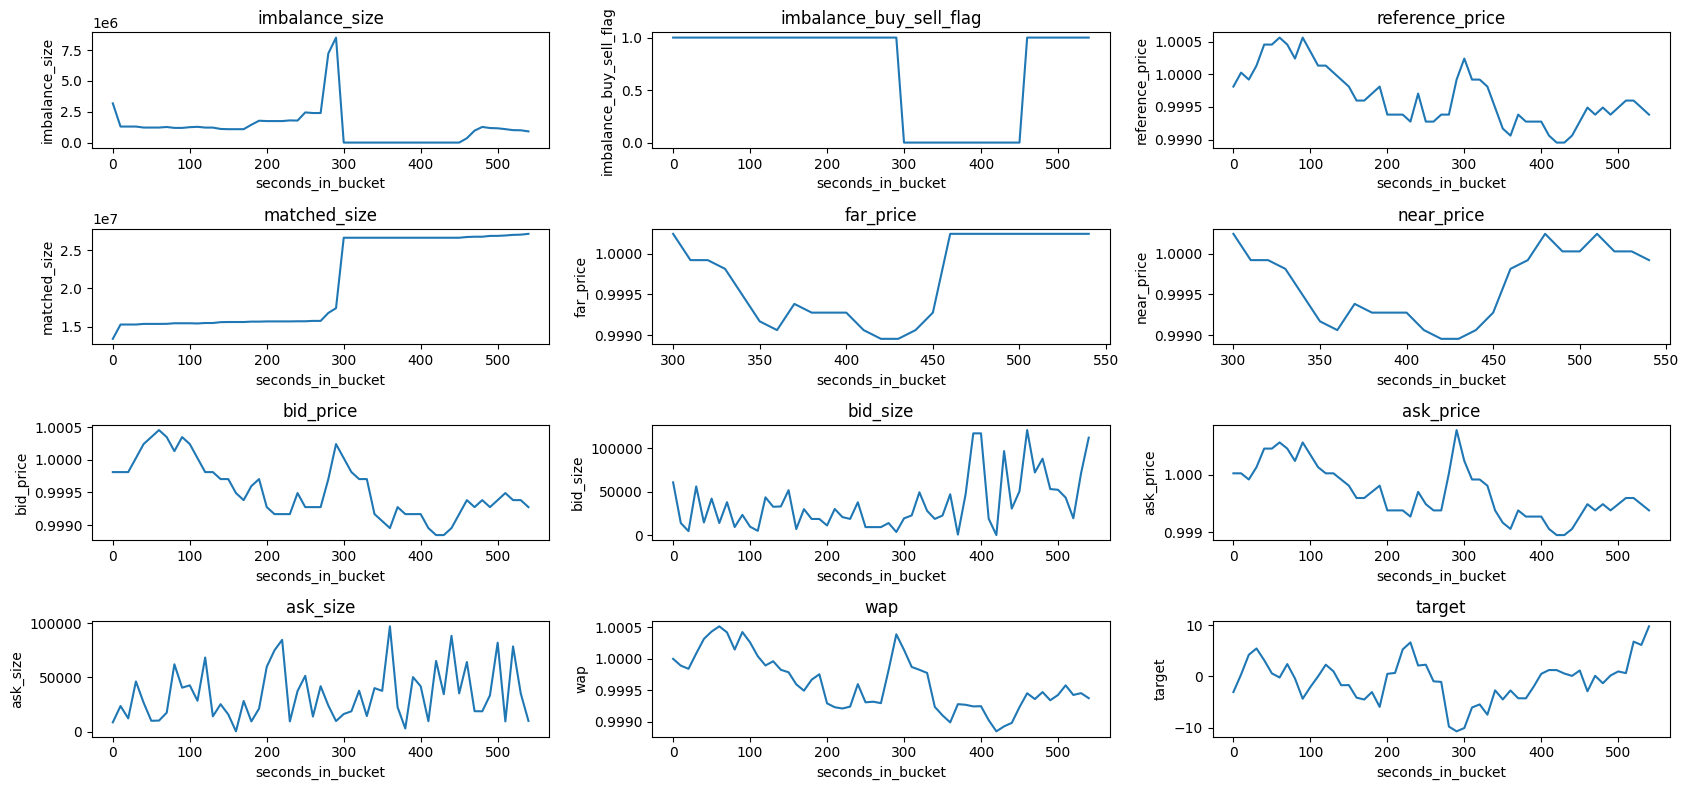

In [ ]:
fig, axes = plt.subplots(4, 3, figsize = (17, 8))
_ = df.query("stock_id == 0 & date_id == 0")
for i, col in enumerate(cols_to_plot):
    ax = axes[i // 3, i % 3 ]
    sns.lineplot(data = _, x = 'seconds_in_bucket', y = col, ax = ax)
    ax.set_title(f"{col}")
plt.tight_layout()
plt.show()

* Correlation matrix for the attributes

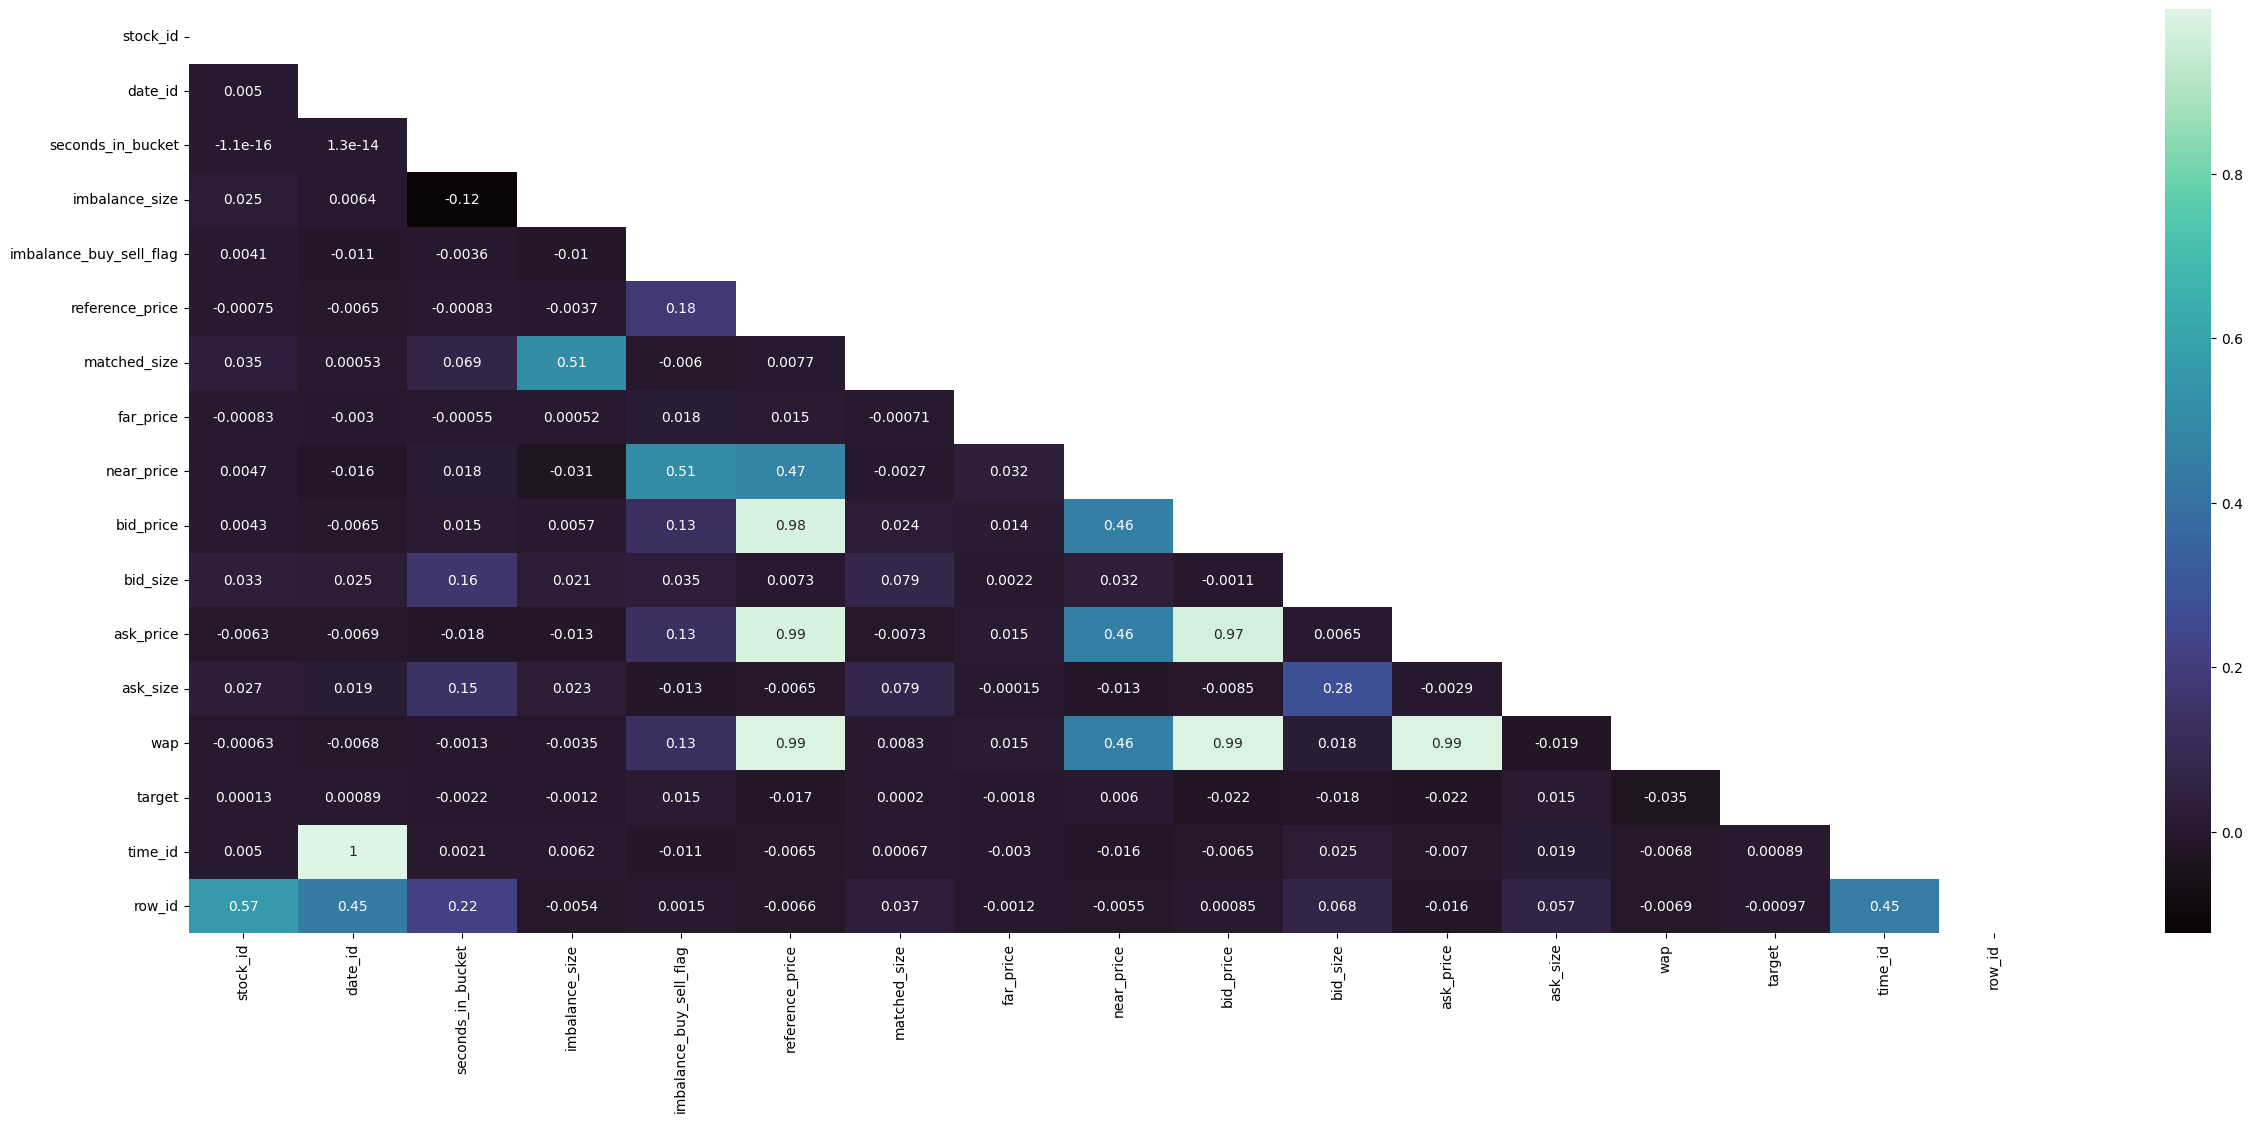

In [ ]:
plt.figure(figsize=(30,12))
corr=df.corr()
sns.heatmap(corr,annot=True,cmap='mako',mask=np.triu(corr))
plt.show()

### Observations:
- None of the features correlate much target
- The correlation between the 'target' variable and the other variables are very less

### Data preparation

In [ ]:
SEED = 42

N_LAGS = 55

BATCH_SIZE = 32
BUFFER_SIZE = 100000
EPOCHS = 50
PATIENCE = 25
DROPOUT = 0.2
LEARNING_RATE = 1e-4

SPLIT_DAY = 390

N_STOCKS = 200
N_DATES = 481
N_SECONDS = 55

In [ ]:
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.keras.utils.set_random_seed(SEED)

In [ ]:
df_org = df.copy()

In [ ]:
df = df[["stock_id", "date_id", "seconds_in_bucket", "target"]]
df.shape

(5237980, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 5237980 entries, 0 to 5237979

Data columns (total 4 columns):

 #   Column             Dtype  

---  ------             -----  

 0   stock_id           int64  

 1   date_id            int64  

 2   seconds_in_bucket  int64  

 3   target             float64

dtypes: float64(1), int64(3)

memory usage: 159.9 MB


### Reducing the memory usage
* The method reduce_mem_usage() attempts to reduce its memory usage by changing the data types of columns to lower memory alternatives when possible.
* The function iterates over each column and checks its data type and the range of values it contains. It then converts the column to a more memory-efficient data type if applicable.
* Reducing the memory usage by truncating some of the data types like int64 -> int16


In [ ]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float32)

    print(f"Memory usage of dataframe is {start_mem:.2f} MB")
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f"Decreased by {decrease:.2f}%")

    return df

df = reduce_mem_usage(df, verbose=1)

Memory usage of dataframe is 159.85 MB

Memory usage after optimization is: 39.96 MB

Decreased by 75.00%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 5237980 entries, 0 to 5237979

Data columns (total 4 columns):

 #   Column             Dtype  

---  ------             -----  

 0   stock_id           int16  

 1   date_id            int16  

 2   seconds_in_bucket  int16  

 3   target             float16

dtypes: float16(1), int16(3)

memory usage: 40.0 MB


### Create Training Dataset with tensorflow Dataset Framework

This function windowed_dataset takes a time series data, converts it into a TensorFlow Dataset, and processes it into overlapping windows. Each window contains a sequence of data points for the model to learn from (features) and the next data point as the target (label). The dataset is then batched and prefetched for efficient training.

In [ ]:
def windowed_dataset(dataset, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(N_LAGS + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(N_LAGS + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(1)
    return dataset

The function build_features takes a DataFrame containing time series data for various stocks and transforms it into a pivoted format suitable for time series analysis and modeling. The function ensures comprehensive coverage by including all combinations of stock IDs, date IDs, and time intervals, and then restructures the data into a pivot table format.

In [ ]:
def build_features(df):

    all_stock_ids = range(N_STOCKS)
    all_date_ids = df["date_id"].unique()
    all_seconds = [i * 10 for i in range(N_SECONDS)]

    multi_index = pd.MultiIndex.from_product([all_stock_ids, all_date_ids, all_seconds],
                                             names=['stock_id', 'date_id', 'seconds_in_bucket'])
    df = df.set_index(['stock_id', 'date_id', 'seconds_in_bucket']).reindex(multi_index)
    df = df.fillna(0)
    df = df.reset_index()

    df_pivoted = df.pivot_table(
                values='target',
                index=['date_id', 'seconds_in_bucket'],
                columns='stock_id')

    df_pivoted = df_pivoted.reset_index(drop=True)
    df_pivoted.columns.name = None

    return df_pivoted

build_features(df)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-3.029297,-5.519531,-8.390625,-4.011719,-7.351562,6.781250,-2.500000,-1.959961,-5.968750,7.968750,...,6.371094,11.937500,-11.531250,-6.488281,4.000000,-0.690430,-0.810059,-8.437500,-0.510254,0.000000
1,0.389893,-1.620117,-7.460938,-1.040039,-6.718750,7.710938,-4.281250,-8.007812,-0.780273,-0.640137,...,4.210938,2.599609,-15.601562,-1.750000,-9.031250,-1.320312,-3.259766,-4.410156,-1.419922,0.000000
2,4.218750,-6.460938,-6.378906,-2.029297,-0.690430,1.009766,2.929688,-12.070312,-4.121094,-3.250000,...,5.378906,-5.968750,-12.710938,2.160156,-10.000000,5.890625,-0.029800,-6.820312,2.599609,0.000000
3,5.449219,-5.148438,-5.820312,1.129883,-2.589844,-3.089844,0.560059,-6.910156,-1.089844,-6.757812,...,-3.269531,1.300781,-16.656250,4.089844,-9.343750,7.019531,1.549805,1.690430,3.009766,0.000000
4,3.169922,-6.750000,-0.280029,-2.349609,-4.898438,-2.070312,2.199219,-1.209961,-3.099609,-8.203125,...,-2.009766,-0.969727,-9.226562,5.699219,-11.492188,4.500000,-1.349609,-1.929688,4.667969,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26450,4.000000,2.849609,-4.449219,1.719727,1.939453,-4.570312,-0.629883,-1.729492,-0.680176,3.541016,...,-4.730469,-7.421875,2.960938,-2.359375,-0.650391,3.189453,-1.660156,-0.690430,-2.699219,-7.210938
26451,3.189453,3.169922,-5.558594,4.667969,2.140625,1.679688,-0.360107,-3.240234,2.609375,1.679688,...,-3.339844,-3.480469,1.419922,-1.070312,2.320312,3.771484,-3.039062,-3.298828,-2.070312,-9.750000
26452,-0.169922,5.691406,-5.308594,5.640625,1.660156,2.109375,-1.000000,-4.531250,5.410156,0.350586,...,-1.549805,-1.290039,-0.140015,-1.929688,4.609375,1.449219,-6.320312,-2.000000,-2.240234,3.630859
26453,3.109375,10.648438,-5.238281,5.230469,0.300293,-2.029297,-1.179688,-1.310547,3.240234,0.220581,...,-1.440430,-0.299805,-2.121094,-1.349609,3.109375,4.019531,-7.351562,-3.259766,-3.160156,4.761719


### Train Test Split
#### splitting the data into train and test set using a split day = 390
- from date 0 - 390, we have the train data
- from 390 to 481, we have test data

In [ ]:
split = df['date_id'] > SPLIT_DAY
df_train = df[~split]
df_valid = df[split]

df_train_features = build_features(df_train)
df_valid_features = build_features(df_valid)

#### Scaling the data using Standard Scaler
* Ensure that the features are on a similar scale
* StandardScaler() standardizes features by removing the mean and scaling to unit variance.

In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(df_train_features)
valid_features = scaler.transform(df_valid_features)

### Creating sequences to give input to LSTM models

In [ ]:
train_dataset = windowed_dataset(train_features)
valid_dataset = windowed_dataset(valid_features, shuffle=False)

### Building LSTM model 1

* The `build_model1` function creates a sequential neural network with an input layer for a 3D input shape representing time lag, number of stocks, and a single LSTM layer with 64 units. The model includes dropout regularization, a dense output layer for predicting stock values, and is compiled with mean absolute error (MAE) loss and the Adam optimizer with a specified learning rate.

In [ ]:
def build_model1(dropout=DROPOUT):
    keras.backend.clear_session()
    tf.keras.utils.set_random_seed(SEED)
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Dropout(dropout))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

In [ ]:
## Evaluate ##
def eval_model(model):
    y_pred = model.predict(valid_dataset)

    y_pred = scaler.inverse_transform(y_pred)
    y_true = df_valid_features[N_LAGS:]

    mae = mean_absolute_error(y_true, y_pred)
    print(f"MAE score: {mae}")

    ## Plots ##
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

* The `EarlyStopping` callback is configured to monitor the validation loss, halt training when the loss stops decreasing (`mode='min'`), and restore the model to its best weights based on validation performance (`restore_best_weights=True`) with a specified patience before stopping (`patience`). The `verbose=True` setting prints messages during the early stopping process.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                  mode='min',
                  patience=PATIENCE,
                  restore_best_weights=True,
                  verbose=True)

In [ ]:
model1 = build_model1()
model1.summary()

history = model1.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping],
                    verbose=True)

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dropout (Dropout)           (None, 55, 200)           0         

                                                                 

 lstm (LSTM)                 (None, 64)                67840     

                                                                 

 dropout_1 (Dropout)         (None, 64)                0         

                                                                 

 dense (Dense)               (None, 200)               13000     

                                                                 


Total params: 80840 (315.78 KB)

Trainable params: 80840 (315.78 KB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________

Epoch 1/50

671/671 [==============================] - 33s 40ms/step - loss: 0.7329 - val_loss: 0.6826

Epoch 2/50

671/671 [========

153/153 [==============================] - 3s 16ms/step

MAE score: 5.3884596824646


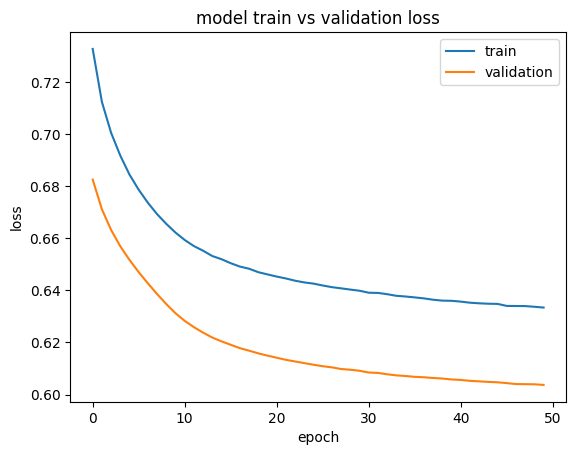

In [ ]:
eval_model(model1)

### **RESULT:**  Model 1 , MAE score  : 5.3884596824646

### LSTM model 2
* The `build_model2` function constructs a sequential neural network with a more complex architecture, including multiple LSTM layers. It has an input layer for a 3D input shape, three LSTM layers with 64 units each (the first two return sequences), dropout regularization between layers, and a dense output layer for predicting stock values. The model is compiled with mean absolute error (MAE) loss and the Adam optimizer with a specified learning rate.

In [ ]:
def build_model2(dropout=DROPOUT):
    keras.backend.clear_session()
    tf.keras.utils.set_random_seed(SEED)
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Dropout(dropout))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

In [ ]:
model2 = build_model2()
model2.summary()
history = model2.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping],
                    verbose=True)

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dropout (Dropout)           (None, 55, 200)           0         

                                                                 

 lstm (LSTM)                 (None, 55, 64)            67840     

                                                                 

 dropout_1 (Dropout)         (None, 55, 64)            0         

                                                                 

 lstm_1 (LSTM)               (None, 55, 64)            33024     

                                                                 

 dropout_2 (Dropout)         (None, 55, 64)            0         

                                                                 

 lstm_2 (LSTM)               (None, 64)                33024     

                                                                 

 dropout_3 (Dropout)         (None, 64) 

153/153 [==============================] - 6s 32ms/step

MAE score: 5.840890884399414


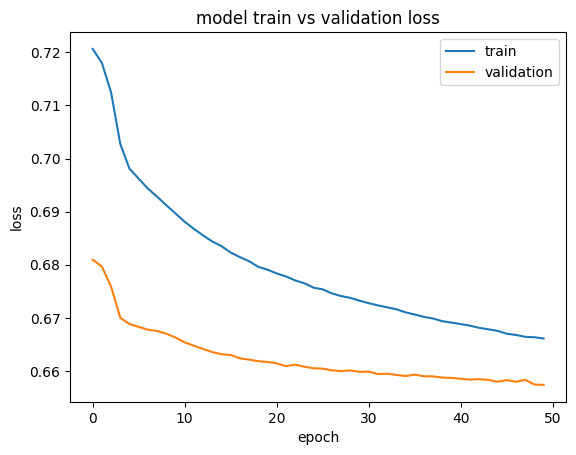

In [ ]:
eval_model(model2)

### **RESULT:** Model 2 , MAE score  : 5.840890884399414

### LSTM model 3
* The `build_model3` function constructs a sequential neural network with a simpler architecture compared to previous models. It includes an input layer for a 3D input shape, a single LSTM layer with 128 units, dropout regularization, and a dense output layer for predicting stock values. The model is compiled with mean absolute error (MAE) loss and the Adam optimizer with a specified learning rate.

In [ ]:
def build_model3(dropout=DROPOUT):
    keras.backend.clear_session()
    tf.keras.utils.set_random_seed(SEED)
    model = Sequential()
    model.add(Input(shape=(N_LAGS, N_STOCKS)))
    model.add(Dropout(dropout))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(N_STOCKS))
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
    return model

In [ ]:
model3 = build_model3()
model3.summary()

history = model3.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping],
                    verbose=True)

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 dropout (Dropout)           (None, 55, 200)           0         

                                                                 

 lstm (LSTM)                 (None, 128)               168448    

                                                                 

 dropout_1 (Dropout)         (None, 128)               0         

                                                                 

 dense (Dense)               (None, 200)               25800     

                                                                 


Total params: 194248 (758.78 KB)

Trainable params: 194248 (758.78 KB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________

Epoch 1/50

671/671 [==============================] - 52s 68ms/step - loss: 0.7327 - val_loss: 0.6765

Epoch 2/50

671/671 [======

153/153 [==============================] - 5s 29ms/step

MAE score: 4.8922224044799805


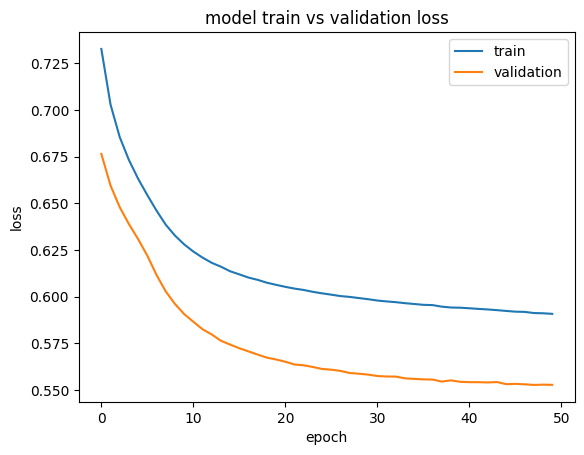

In [ ]:
eval_model(model3)

### **RESULT:** Model 3 , MAE score : 4.8922224044799805

### Analysis of results:

In [ ]:
result = {
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'MAE score': [5.388, 5.840, 4.892]
}

results_df = pd.DataFrame(result)
results_df

,Model,MAE score
0,Model 1,5.388
1,Model 2,5.840
2,Model 3,4.892


**We have Model 3 for submission in the competition as Model 3 has the best performance**

### Conclusion
The three models were evaluated based on Mean Absolute Error (MAE) scores, with Model 3 achieving the lowest MAE score of 4.892, indicating superior performance compared to Models 1 and 2. Model 1 follows closely with an MAE score of 5.388, while Model 2 lags slightly behind with a higher MAE score of 5.840. In summary, `Model 3` demonstrates the best predictive accuracy among the evaluated models.

### Code for submission

In [ ]:
import optiver2023
optiver2023.make_env.func_dict['__called__'] = False
env = optiver2023.make_env()
iter_test = env.iter_test()

counter = 0

for i, (test, revealed_targets, sample_prediction) in enumerate(iter_test):

    if test.currently_scored.iloc[0]== False:
        sample_prediction['target'] = 0
        env.predict(sample_prediction)
        counter += 1
        continue

    if test.seconds_in_bucket.unique()[0] == 0:

        df_revealed_targets = revealed_targets[["stock_id", "revealed_date_id", "seconds_in_bucket", "revealed_target"]]
        df_revealed_targets = df_revealed_targets.rename(columns={'revealed_date_id': 'date_id', 'revealed_target': 'target'})

        df_features = build_features(df_revealed_targets)

        history_scaled = scaler.transform(df_features)

    y_pred_scaled = model3.predict(
        history_scaled[-N_LAGS:][np.newaxis, :, :],
        verbose=True)

    y_pred = scaler.inverse_transform(y_pred_scaled)

    sample_prediction['target'] = y_pred[0]
    env.predict(sample_prediction)
    counter += 1

    history_scaled = np.concatenate([history_scaled, y_pred_scaled])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
